# Text Classification: Classical Approach

In [66]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielmedina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load dataset

In [67]:
# Load the dataset
data = pd.read_csv('cleaned_data_sw.csv')  # Adjust the path as necessary

## Preprocess

In [68]:
# Define the preprocess function
def preprocess(data_series):
    """
    Preprocess the text data by removing special characters and digits, tokenizing, and stemming and lemmatizing the words.
    Input: data_series - a pandas Series containing the text data to be preprocessed
    Output: preprocessed_data - a pandas Series containing the preprocessed text data
    """
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Function to clean and preprocess text
    def clean_text(text):
        # Convert text to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize and remove stopwords, then stem and lemmatize
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    # Apply the cleaning function to the dataset
    preprocessed_data = data_series.apply(clean_text)
    return preprocessed_data

## Extract Features

In [69]:
def extract_features(preprocessed_data):
    """
    Extract features from the preprocessed data using TF-IDF.
    Input: preprocessed_data - a pandas DataFrame containing the preprocessed text data
    Output: features_df - a pandas DataFrame containing the TF-IDF features
    """
    # Initialize a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=150)  # You can adjust the number of features
    
    # Fit and transform the preprocessed tweets to create TF-IDF features
    tfidf_features = vectorizer.fit_transform(preprocessed_data['preprocessed_tweet'])
    
    # Convert the TF-IDF features to a dense matrix, then to a DataFrame
    features_df = pd.DataFrame(tfidf_features.toarray())
    
    # Add the 'class' column from the original data
    features_df['class'] = preprocessed_data['class'].values
    
    return features_df

## Split data

In [70]:
def split_data(data_features, test_size=0.2, val_size=0.25):
    """
    Splits data into training, validation, and testing sets.
    
    Parameters:
    - data_features: DataFrame containing features and class labels.
    - test_size: Proportion of the dataset to include in the test split (default: 0.2).
    - val_size: Proportion of the training dataset to include in the validation split (default: 0.25).
    
    Returns:
    - X_train, y_train: Features and labels for the training set.
    - X_val, y_val: Features and labels for the validation set.
    - X_test, y_test: Features and labels for the test set.
    """
    # Separate features and class labels
    X = data_features.iloc[:, :-1]  # Assuming the last column is the class label
    y = data_features.iloc[:, -1]
    
    # First split to separate out the test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Second split to separate out the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)  # val_size here is relative to X_temp
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [71]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(features_df)

## Train Model

In [72]:
def train_model(model, X_train, y_train):
    """
    Trains a machine learning model using the provided training data.

    Parameters:
    - model: The machine learning model to be trained.
    - X_train: The features of the training data.
    - y_train: The labels of the training data.

    Returns:
    - The trained model.
    """
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Return the trained model
    return model

## Tune Hyperparameters

In [73]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(model, param_grid, X_val, y_val):
    """
    Tunes hyperparameters for the given model using GridSearchCV on the validation set.

    Parameters:
    - model: The machine learning model whose hyperparameters are to be tuned.
    - param_grid: The hyperparameter settings to try as a dictionary.
    - X_val: The features of the validation data.
    - y_val: The labels of the validation data.

    Returns:
    - best_model: The model with the best parameters found.
    - best_params: The best parameter settings found.
    """
    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')  # You can change scoring to another metric.
    
    # Fit GridSearchCV to the validation data
    grid_search.fit(X_val, y_val)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Return the best model and parameters
    return best_model, best_params

## Evaluate Model

In [74]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained machine learning model using the test set and generates a confusion matrix.

    Parameters:
    - model: The trained machine learning model.
    - X_test: The features of the test data.
    - y_test: The labels of the test data.

    Returns:
    - A dictionary containing the evaluated metrics: accuracy, precision, recall, and F1-score, and a confusion matrix.
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Change 'binary' to 'macro' or 'weighted' for multi-class
    recall = recall_score(y_test, y_pred, average='binary')  # Change 'binary' to 'macro' or 'weighted' for multi-class
    f1 = f1_score(y_test, y_pred, average='binary')  # Change 'binary' to 'macro' or 'weighted' for multi-class
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Compile and return the metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

    return metrics, conf_matrix


## Model Pipeline

In [75]:
def model_pipeline(raw_data, model, param_grid):
    """
    Executes the machine learning pipeline: preprocessing, feature extraction,
    data splitting, training, hyperparameter tuning, and evaluation.

    Parameters:
    - raw_data: The raw dataset containing 'tweet' and 'class' columns.
    - model: An instance of a machine learning model to be trained.
    - param_grid: The grid of parameters to tune for the model.

    Returns:
    - tuned_model: The trained and tuned model.
    - evaluation_metrics: The evaluation metrics of the tuned model on the test set.
    """

    # drop columns Unnamed: 0,count,hate_speech,offensive_language,neither
    raw_data = raw_data.drop(columns=['Unnamed: 0','count','hate_speech','offensive_language','neither'])

    # Step 1: Preprocess the data
    raw_data['tweet'] = preprocess(raw_data['tweet'])
    # rename the column 'tweet' to 'preprocessed_tweet'
    raw_data.rename(columns = {'tweet':'preprocessed_tweet'}, inplace = True)

    # Step 2: Extract features
    data_features = extract_features(raw_data)

    # Step 3: Split the data into training, validation, and testing sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(data_features)

    # Step 4: Train the model
    trained_model = train_model(model, X_train, y_train)

    # Step 5: Tune hyperparameters (using the validation set)
    tuned_model, best_params = tune_hyperparameters(trained_model, param_grid, X_val, y_val)

    # Step 6: Evaluate the tuned model (using the test set)
    evaluation_metrics, conf_matrix = evaluate_model(tuned_model, X_test, y_test)

    # Return the tuned model and its evaluation metrics
    return tuned_model, evaluation_metrics, conf_matrix

### Train SVM

accuracy: 0.9184990921928586
precision: 0.7110675808031341
recall: 0.8694610778443114
f1_score: 0.7823275862068966
confusion_matrix: [[3827  295]
 [ 109  726]]


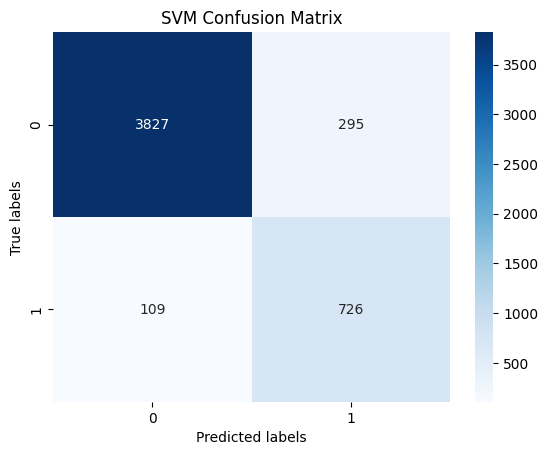

In [76]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Specifies the kernel type
}

# Initialize the model
model = SVC()

# Execute the pipeline
tuned_model, evaluation_metrics, conf_matrix = model_pipeline(data, model, param_grid)

# Print the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f'{metric}: {value}')

# Print and plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Confusion Matrix')
plt.show()

### Train Random Forest

/Users/danielmedina/Documents/Duke/classes/spring-2024/aipi540/no_hate_transformer/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
900 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/danielmedina/Documents/Duke/classes/spring-2024/aipi540/no_hate_transformer/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danielmedina/Documents/Duke/classes/spring-2024/aipi540/no_hate_transformer/env/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrap

accuracy: 0.9142626588662498
precision: 0.7308558558558559
recall: 0.7772455089820359
f1_score: 0.7533372025536854
confusion_matrix: [[3883  239]
 [ 186  649]]


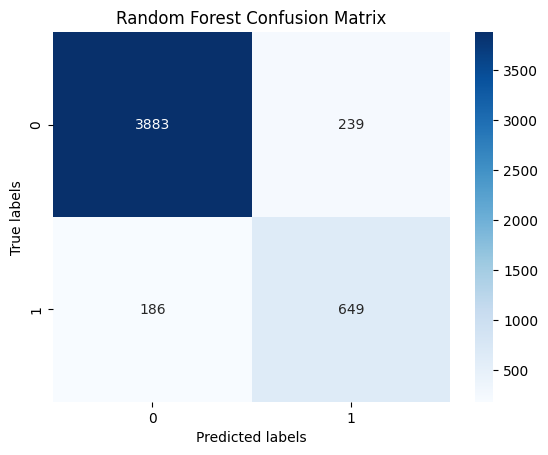

In [77]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest model
model = RandomForestClassifier()

# Execute the pipeline
tuned_model, evaluation_metrics, conf_matrix = model_pipeline(data, model, param_grid)

# Print the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f'{metric}: {value}')

# Print and plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()